In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/almond-types-classification/Almond.csv


In [2]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, RandomForestClassifier, VotingClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier

In [3]:
path = "/kaggle/input/almond-types-classification/Almond.csv"

almond_df = pd.read_csv(path).drop(columns=["Unnamed: 0"])
target_col = "Type"
target = almond_df[target_col]

almond_df["Positioning"] = 0

for row in almond_df.iterrows():
    if pd.isna(row[1]["Width (minor axis)"]):
        almond_df.at[row[0], "Positioning"] = 1
    elif pd.isna(row[1]["Thickness (depth)"]):
        almond_df.at[row[0], "Positioning"] = 2

almond_df.head()

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type,Positioning
0,NaN,227.940628,127.759132,22619.0,643.813269,NaN,0.973384,1.458265,NaN,NaN,0.681193,23237.5,MAMRA,0
1,NaN,234.188126,128.199509,23038.0,680.984841,NaN,0.957304,1.601844,NaN,NaN,0.656353,24065.5,MAMRA,0
2,NaN,229.418610,125.796547,22386.5,646.943212,NaN,0.967270,1.487772,NaN,NaN,0.683620,23144.0,MAMRA,0
3,NaN,232.763153,125.918808,22578.5,661.227483,NaN,0.965512,1.540979,NaN,NaN,0.685360,23385.0,MAMRA,0
4,NaN,230.150742,107.253448,19068.0,624.842706,NaN,0.951450,1.629395,NaN,NaN,0.714800,20041.0,MAMRA,0


In [4]:
def report(dfs, names):
    
    rep = pd.DataFrame(dfs[0].dtypes, columns=['dtypes'])
    
    for i, df in enumerate(dfs):
        rep[f"{names[i]}_missing#"] = dfs[i].isna().sum()
        rep[f"{names[i]}_missing%"] = (dfs[i].isna().sum())/len(dfs[i])
        rep[f"{names[i]}_uniques"] = dfs[i].nunique().values

    return rep

In [5]:
dfs = [almond_df]
names = ["Almond DF"]
rep = report(dfs, names)
rep.style.background_gradient(cmap="YlOrBr")

,dtypes,Almond DF_missing#,Almond DF_missing%,Almond DF_uniques
Length (major axis),float64,857,0.305744,1944
Width (minor axis),float64,942,0.336068,1859
Thickness (depth),float64,1004,0.358188,1797
Area,float64,0,0.000000,2750
Perimeter,float64,0,0.000000,2793
Roundness,float64,857,0.305744,1944
Solidity,float64,0,0.000000,2800
Compactness,float64,0,0.000000,2800
Aspect Ratio,float64,1799,0.641812,1003
Eccentricity,float64,1799,0.641812,1003


In [6]:
almond_df2 = almond_df.copy()


In [7]:
e = 1e-5
iter_num = 3

encoder = LabelEncoder()
almond_df2[target_col] = encoder.fit_transform(almond_df2[target_col])

na_cols = ["Length (major axis)", "Width (minor axis)", "Thickness (depth)"]
na_rows = {col: almond_df2[almond_df2[col].isna()].copy() for col in na_cols}

for i in tqdm(range(iter_num)):
    for col in na_cols:
        
        non_na_rows = almond_df2.drop(index=na_rows[col].index).copy()
        
        x_train = non_na_rows.drop([col], axis=1).copy()
        y_train = non_na_rows[col].copy()

        x_test = na_rows[col].drop(col, axis=1)
        
        cb_imputer = CatBoostRegressor(verbose=0)
        cb_imputer.fit(x_train, y_train)
        
        y_pred = cb_imputer.predict(x_test)
        
        almond_df2.loc[na_rows[col].index, col] = y_pred
    
    almond_df2["Roundness"] = 4 * almond_df2["Area"] / ( np.pi * almond_df2["Length (major axis)"] ** 2 + e)
    almond_df2["Aspect Ratio"] = almond_df2["Length (major axis)"] / (almond_df2["Width (minor axis)"]+e)
    almond_df2["Eccentricity"] = np.sqrt(1 - (almond_df2["Width (minor axis)"] / (almond_df2["Length (major axis)"] + e)) **2 )

almond_df2[target_col] = encoder.inverse_transform(almond_df2[target_col])

100%|██████████| 3/3 [00:19<00:00,  6.58s/it]


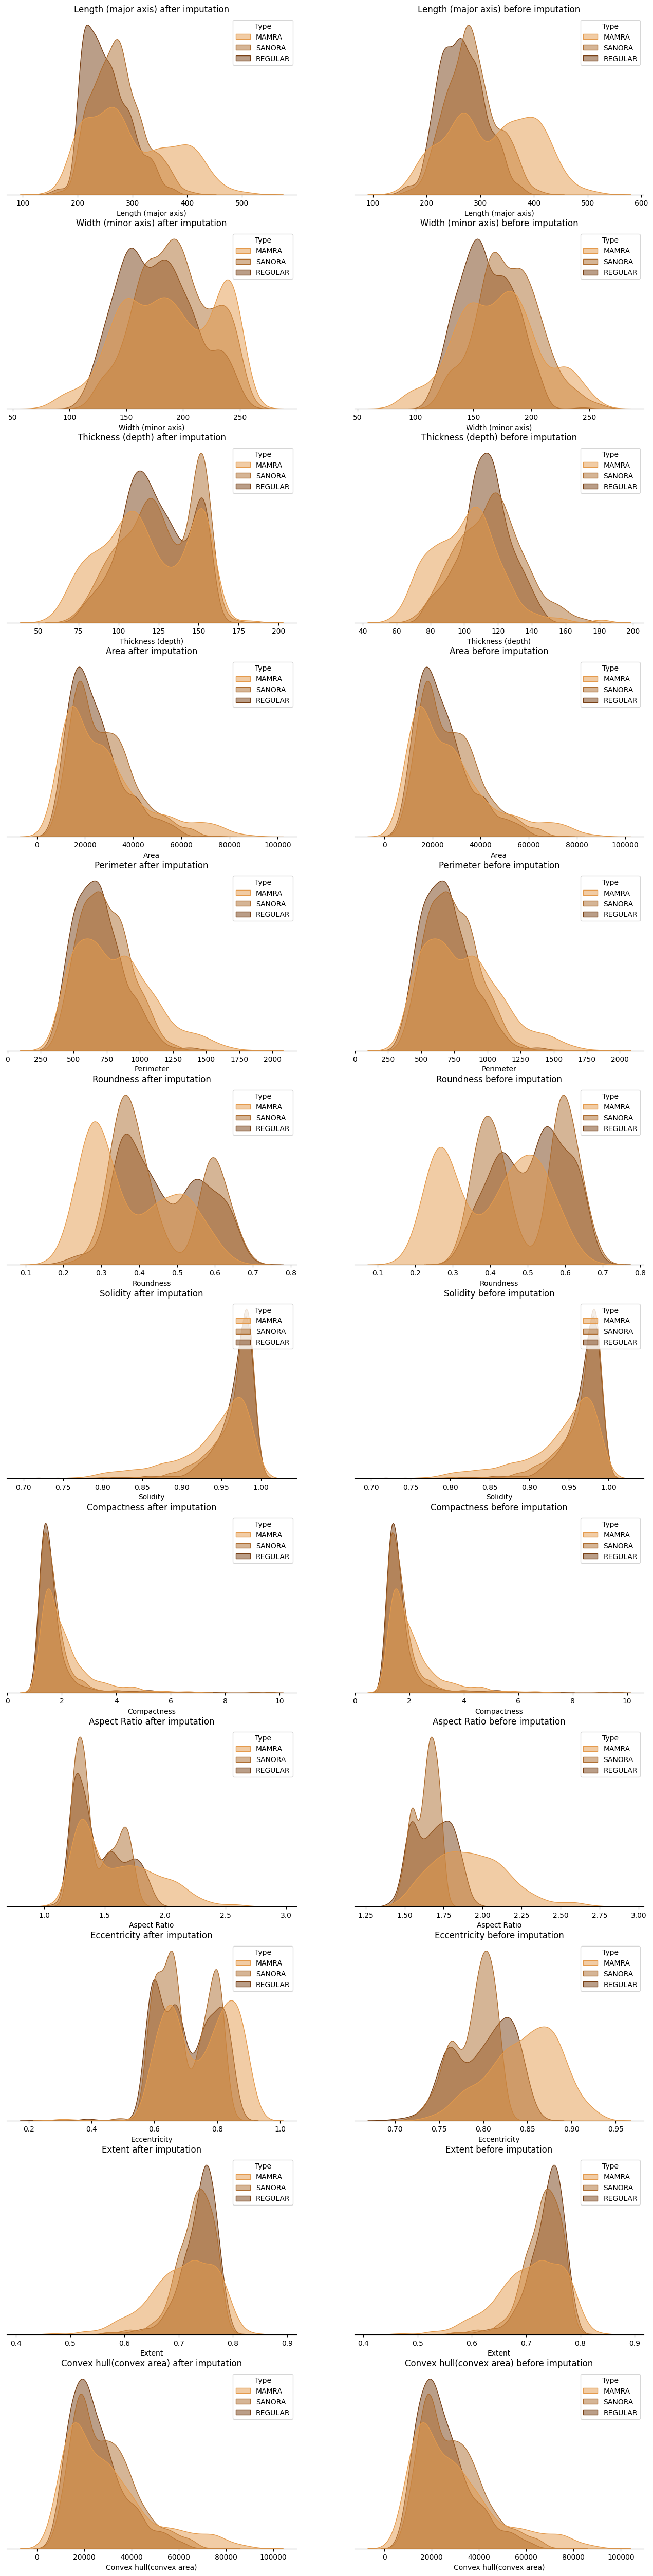

In [8]:
columns = almond_df2.drop([target_col, "Positioning"], axis=1).columns
fig, axes = plt.subplots(len(columns), 2, figsize=(16, 64))

for i, col in enumerate(columns):
    
    sns.kdeplot(data=almond_df2, x=col, hue=target_col,
                ax=axes[i, 0], fill=True,
                palette="blend:#e49a4c,#773e13", alpha=.5)
    
    axes[i, 0].set_title(f"{col} after imputation")
    axes[i, 0].set_yticklabels("")
    axes[i, 0].set_ylabel("")
    axes[i, 0].tick_params(axis="y",length=0)
    
    sns.kdeplot(data=almond_df, x=col, hue=target_col,
                ax=axes[i, 1], fill=True,
                palette="blend:#e49a4c,#773e13", alpha=.5)
    axes[i, 1].set_title(f"{col} before imputation")
    axes[i, 1].set_yticklabels("")
    axes[i, 1].set_ylabel("")
    axes[i, 1].tick_params(axis="y",length=0)
    
    for direction in ["top","right","left"]:
        axes[i, 0].spines[direction].set_visible(False)
        axes[i, 1].spines[direction].set_visible(False)
        
        
plt.show()

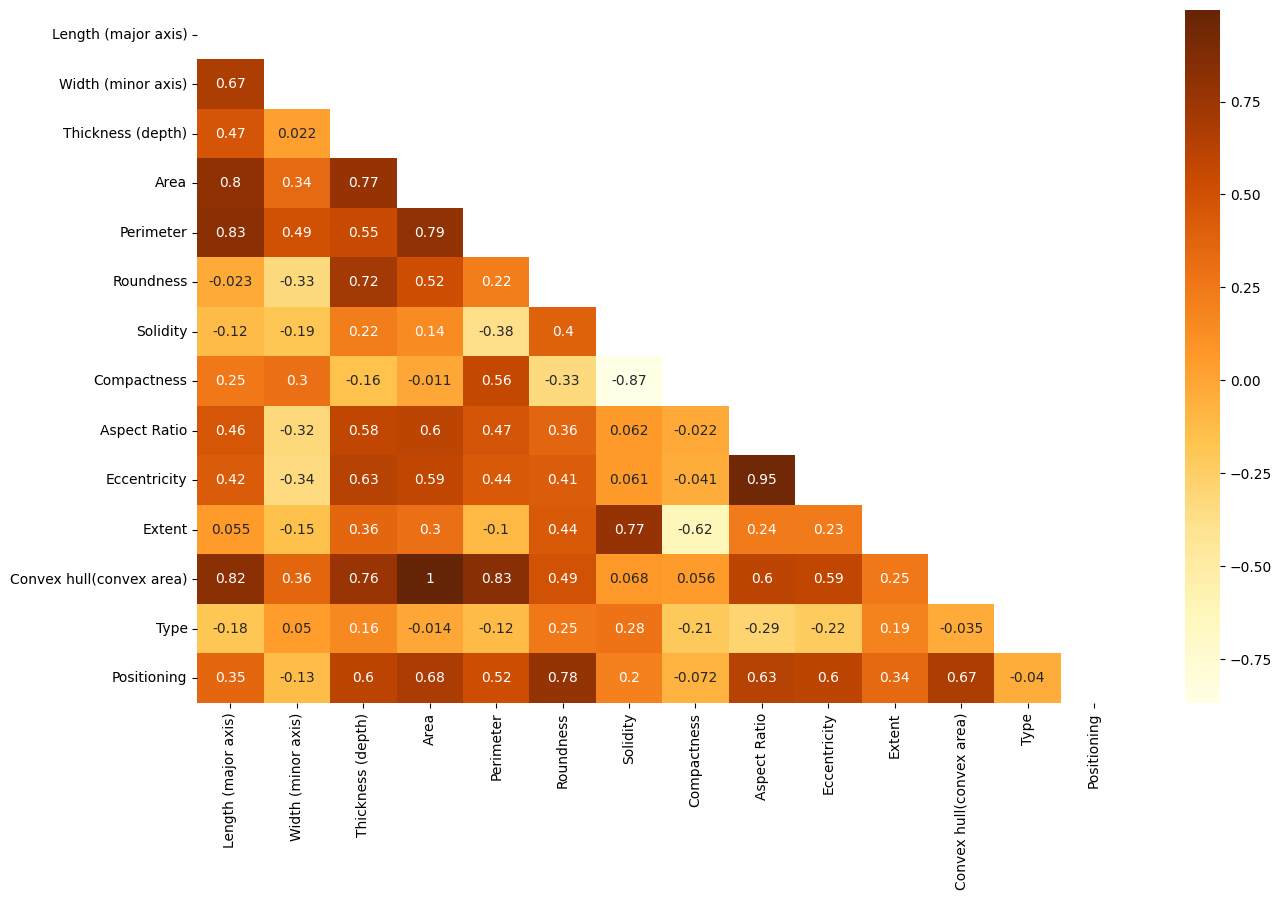

In [9]:
almond_df2[target_col] = encoder.fit_transform(almond_df2[target_col])

corr = almond_df2.corr()
mask = np.triu(np.ones_like(corr))
plt.figure(figsize = (15,9))
sns.heatmap(corr,annot = True, cmap="YlOrBr", mask=mask)
plt.show()

In [10]:
X_train, X_val, y_train, y_val = train_test_split(almond_df2.drop(target_col, axis=1), almond_df2[target_col],
                                                  test_size=.25, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2102, 13), (701, 13), (2102,), (701,))

In [11]:
models = [
    ("cb", CatBoostClassifier(verbose=0)),
    ("rf", RandomForestClassifier()),
    ("xgb", XGBClassifier(verbosity=0)),
    ("lgbm", LGBMClassifier(verbose=0))
         ]

In [12]:
ens_model = VotingClassifier(models, flatten_transform=False, voting="soft")
ens_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


VotingClassifier(estimators=[('cb',
                              <catboost.core.CatBoostClassifier object at 0x7e6d8c0482b0>),
                             ('rf', RandomForestClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_type...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('lgbm', LGBMClassifier(verbose=0))],
                 flatten_transform=False, voting='soft')

In [13]:
y_val_pred = ens_model.predict(X_val)

acc = accuracy_score(y_val, y_val_pred)
acc_report = classification_report(y_val, y_val_pred)
print(acc_report)

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       238
           1       0.82      0.81      0.81       232
           2       0.79      0.81      0.80       231

    accuracy                           0.85       701
   macro avg       0.85      0.85      0.85       701
weighted avg       0.85      0.85      0.85       701

